# Disease dagnosis with machine learning
## Diagnising common diseases among Nigeria student.

In [1]:
! pip install xgboost --quiet
! pip install catboost --quiet
! pip install shap --quiet
! pip install lightgbm --quiet
! pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [19]:
# importing the needed library
import shap
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from joblib import dump
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_data = pd.read_csv('/content/Training.csv')
test_data = pd.read_csv('/content/Testing.csv')

In [4]:
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [5]:
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [6]:
train_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'Unnamed: 133'],
      dtype='object', length=134)

The top disease common among Nigeria students are: Common Cold, Urinary tract infection, Pneumonia, Bronchial Asthma, Acne, Migraine, Hypertension, Gastroenteritis, Allergy, Tuberculosis, Peptic ulcer diseae, Typhoid, Hepatitis B, Hepatitis C, Hepatitis A, Hepatitis E, Malaria, Chickenpox, Diabetes.

In [7]:
#select only the instance in which the target is equal to the common diseases

common_disease = ['Peptic ulcer diseae', 'Diabetes ', 'Gastroenteritis', 'Common Cold', 'Malaria', 'Chicken pox', 'hepatitis A', 'Migraine', 'Hypertension ',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Urinary tract infection', 'Bronchial Asthma', 'Pneumonia', 'Acne', 'Allergy', 'Typhoid',
                  'Tuberculosis',]

train_data = train_data[train_data['prognosis'].isin(common_disease)]

In [8]:
train_data.isnull().values.any()

True

In [9]:
train_data['prognosis'].value_counts()

Allergy                    120
Peptic ulcer diseae        120
Acne                       120
Pneumonia                  120
Common Cold                120
Tuberculosis               120
Hepatitis E                120
Hepatitis D                120
Hepatitis C                120
Hepatitis B                120
hepatitis A                120
Typhoid                    120
Chicken pox                120
Malaria                    120
Migraine                   120
Hypertension               120
Bronchial Asthma           120
Gastroenteritis            120
Diabetes                   120
Urinary tract infection    120
Name: prognosis, dtype: int64

In [10]:
len(train_data['prognosis'].value_counts())

20

In [11]:
train_data.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Unnamed: 133
count,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.00000,2400.0,...,2400.000000,2400.000000,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,0.0
mean,0.095000,0.095000,0.0,0.092500,0.045000,0.285000,0.142500,0.0,0.04750,0.0,...,0.045000,0.045000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,0.293276,0.293276,0.0,0.289791,0.207347,0.451509,0.349635,0.0,0.21275,0.0,...,0.207347,0.207347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75%,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,0.0,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
train_data.shape

(2400, 134)

### Feature selection based on weight and correlation

<Axes: >

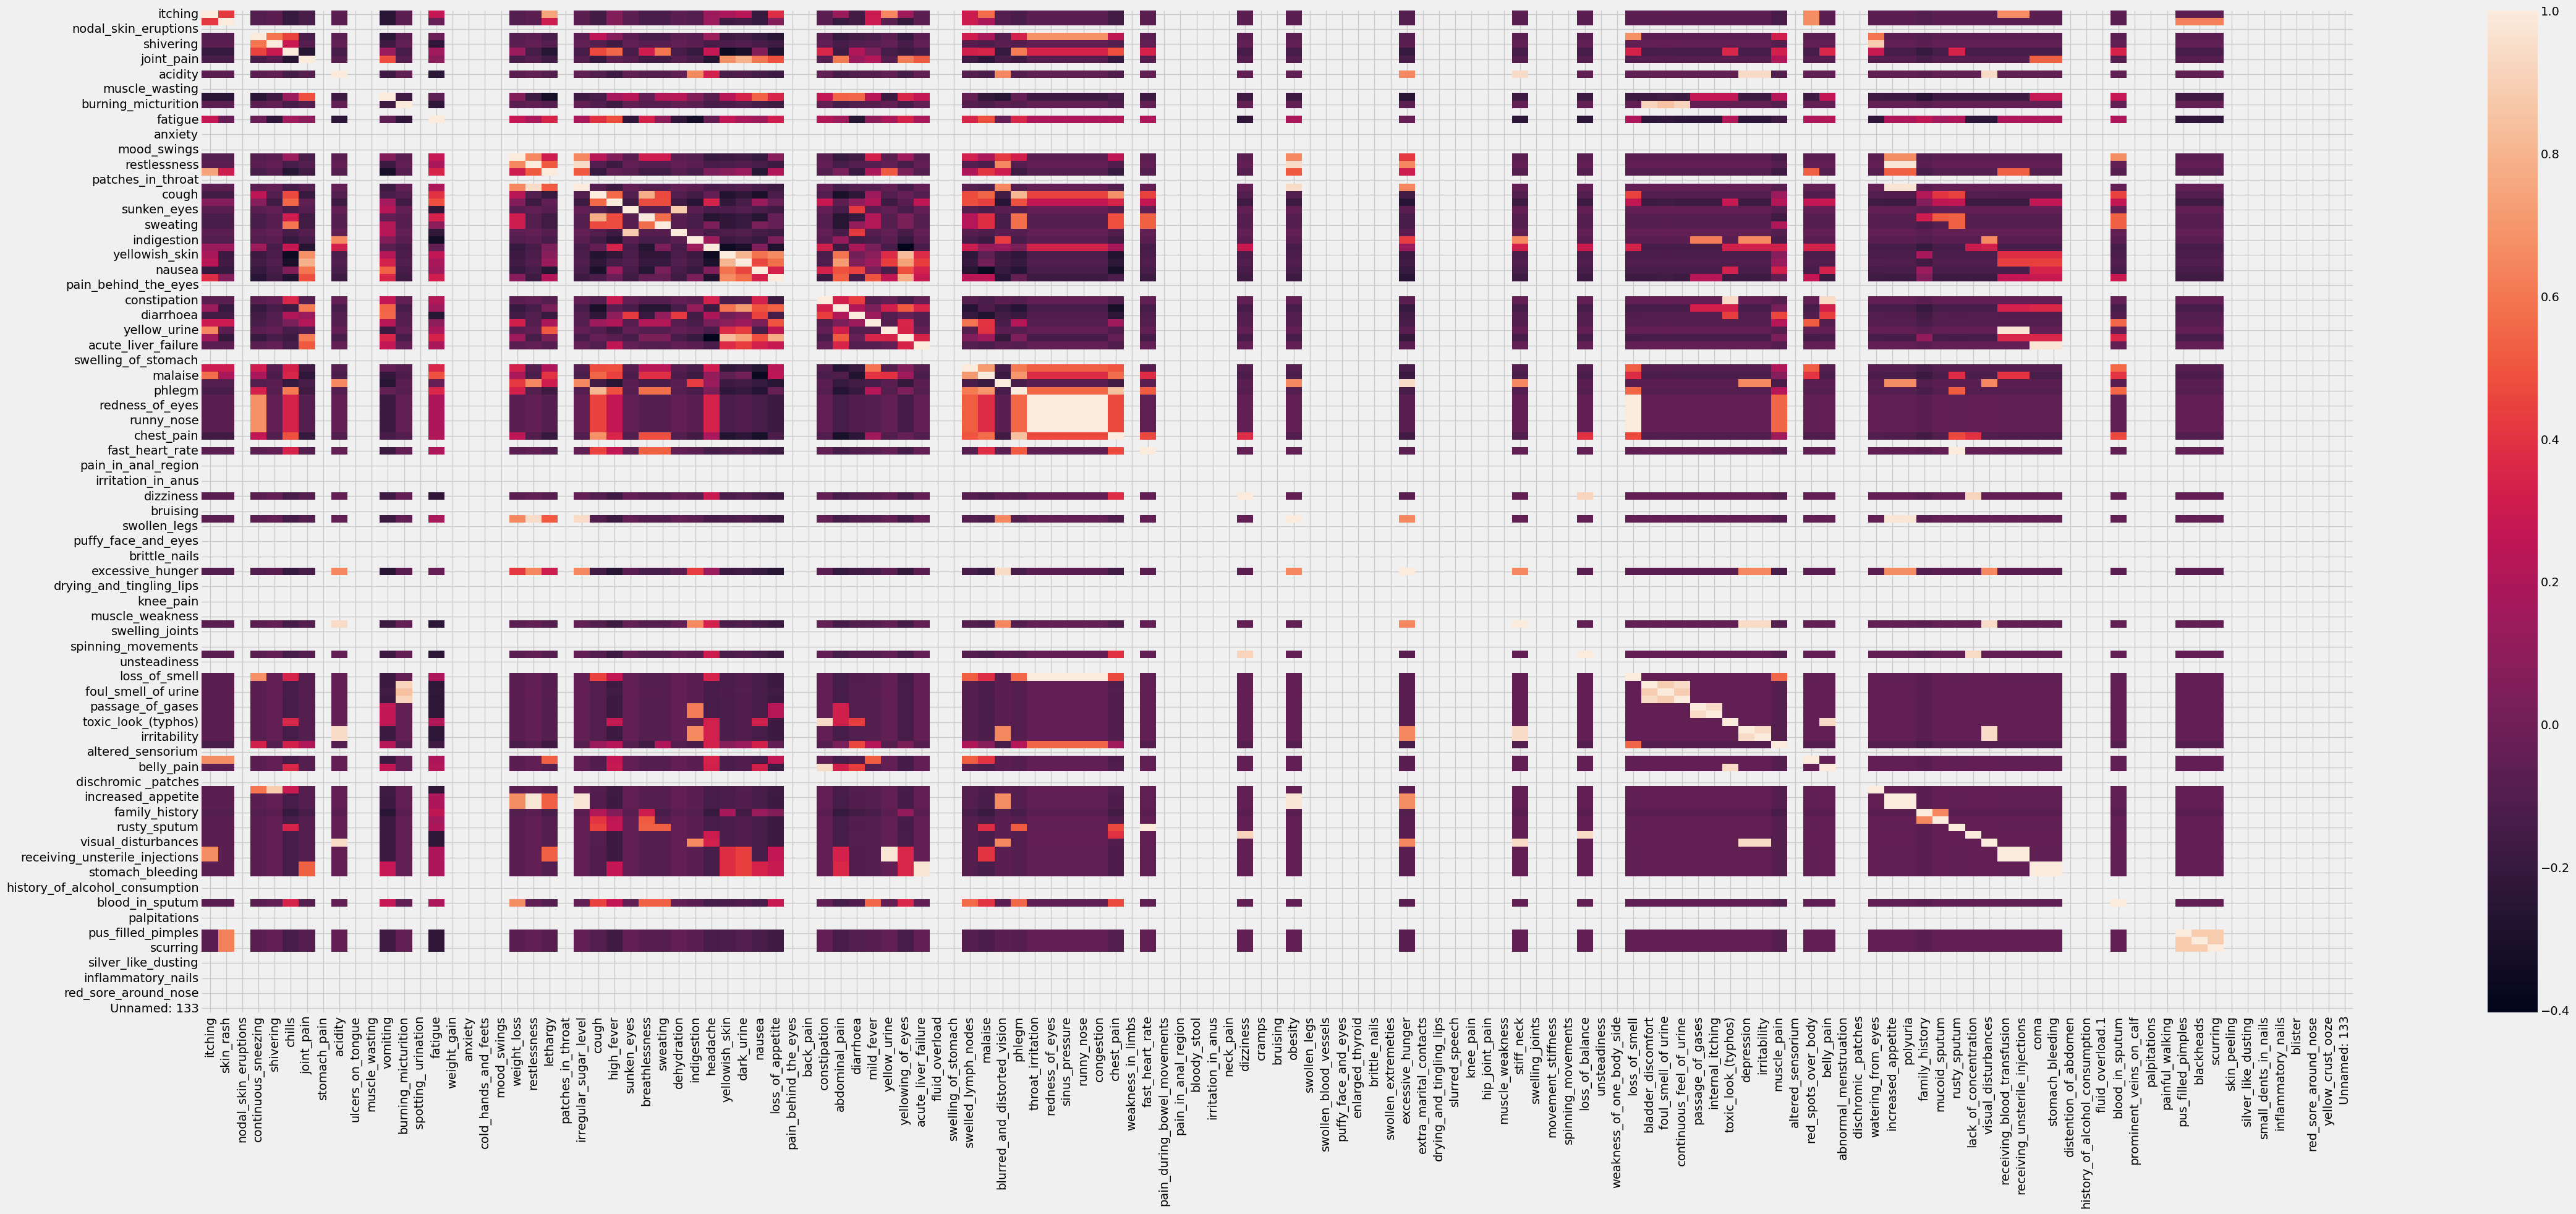

In [13]:
plt.figure(figsize = (50, 20))
sns.heatmap(train_data.corr())

In [14]:
# Dropping the correlated values with 80% and above correlation

corr_matrix = train_data.corr()

corr_threshold = 0.8

# Find and remove correlated features
col_to_remove = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            col_name = corr_matrix.columns[i]
            col_to_remove.add(col_name)

tdata = train_data.drop(columns=col_to_remove)

In [15]:
tdata.shape

(2400, 99)

After dropping the features with 80%. The features dropped significantly from 134 to 99

In [16]:
le = LabelEncoder()
x = tdata.drop(['prognosis'], axis = 1)# independent features
y = le.fit_transform(tdata['prognosis'])# dependent features

In [17]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 3)

In [21]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
#checking if xgboost is overfitted or underfitted with with cross validation
scores = cross_val_score(XGBClassifier(), x_train, y_train,
                              cv = 10,
                              scoring="accuracy")

print("Mean accuracy score: ", scores.mean())

Mean accuracy score:  1.0


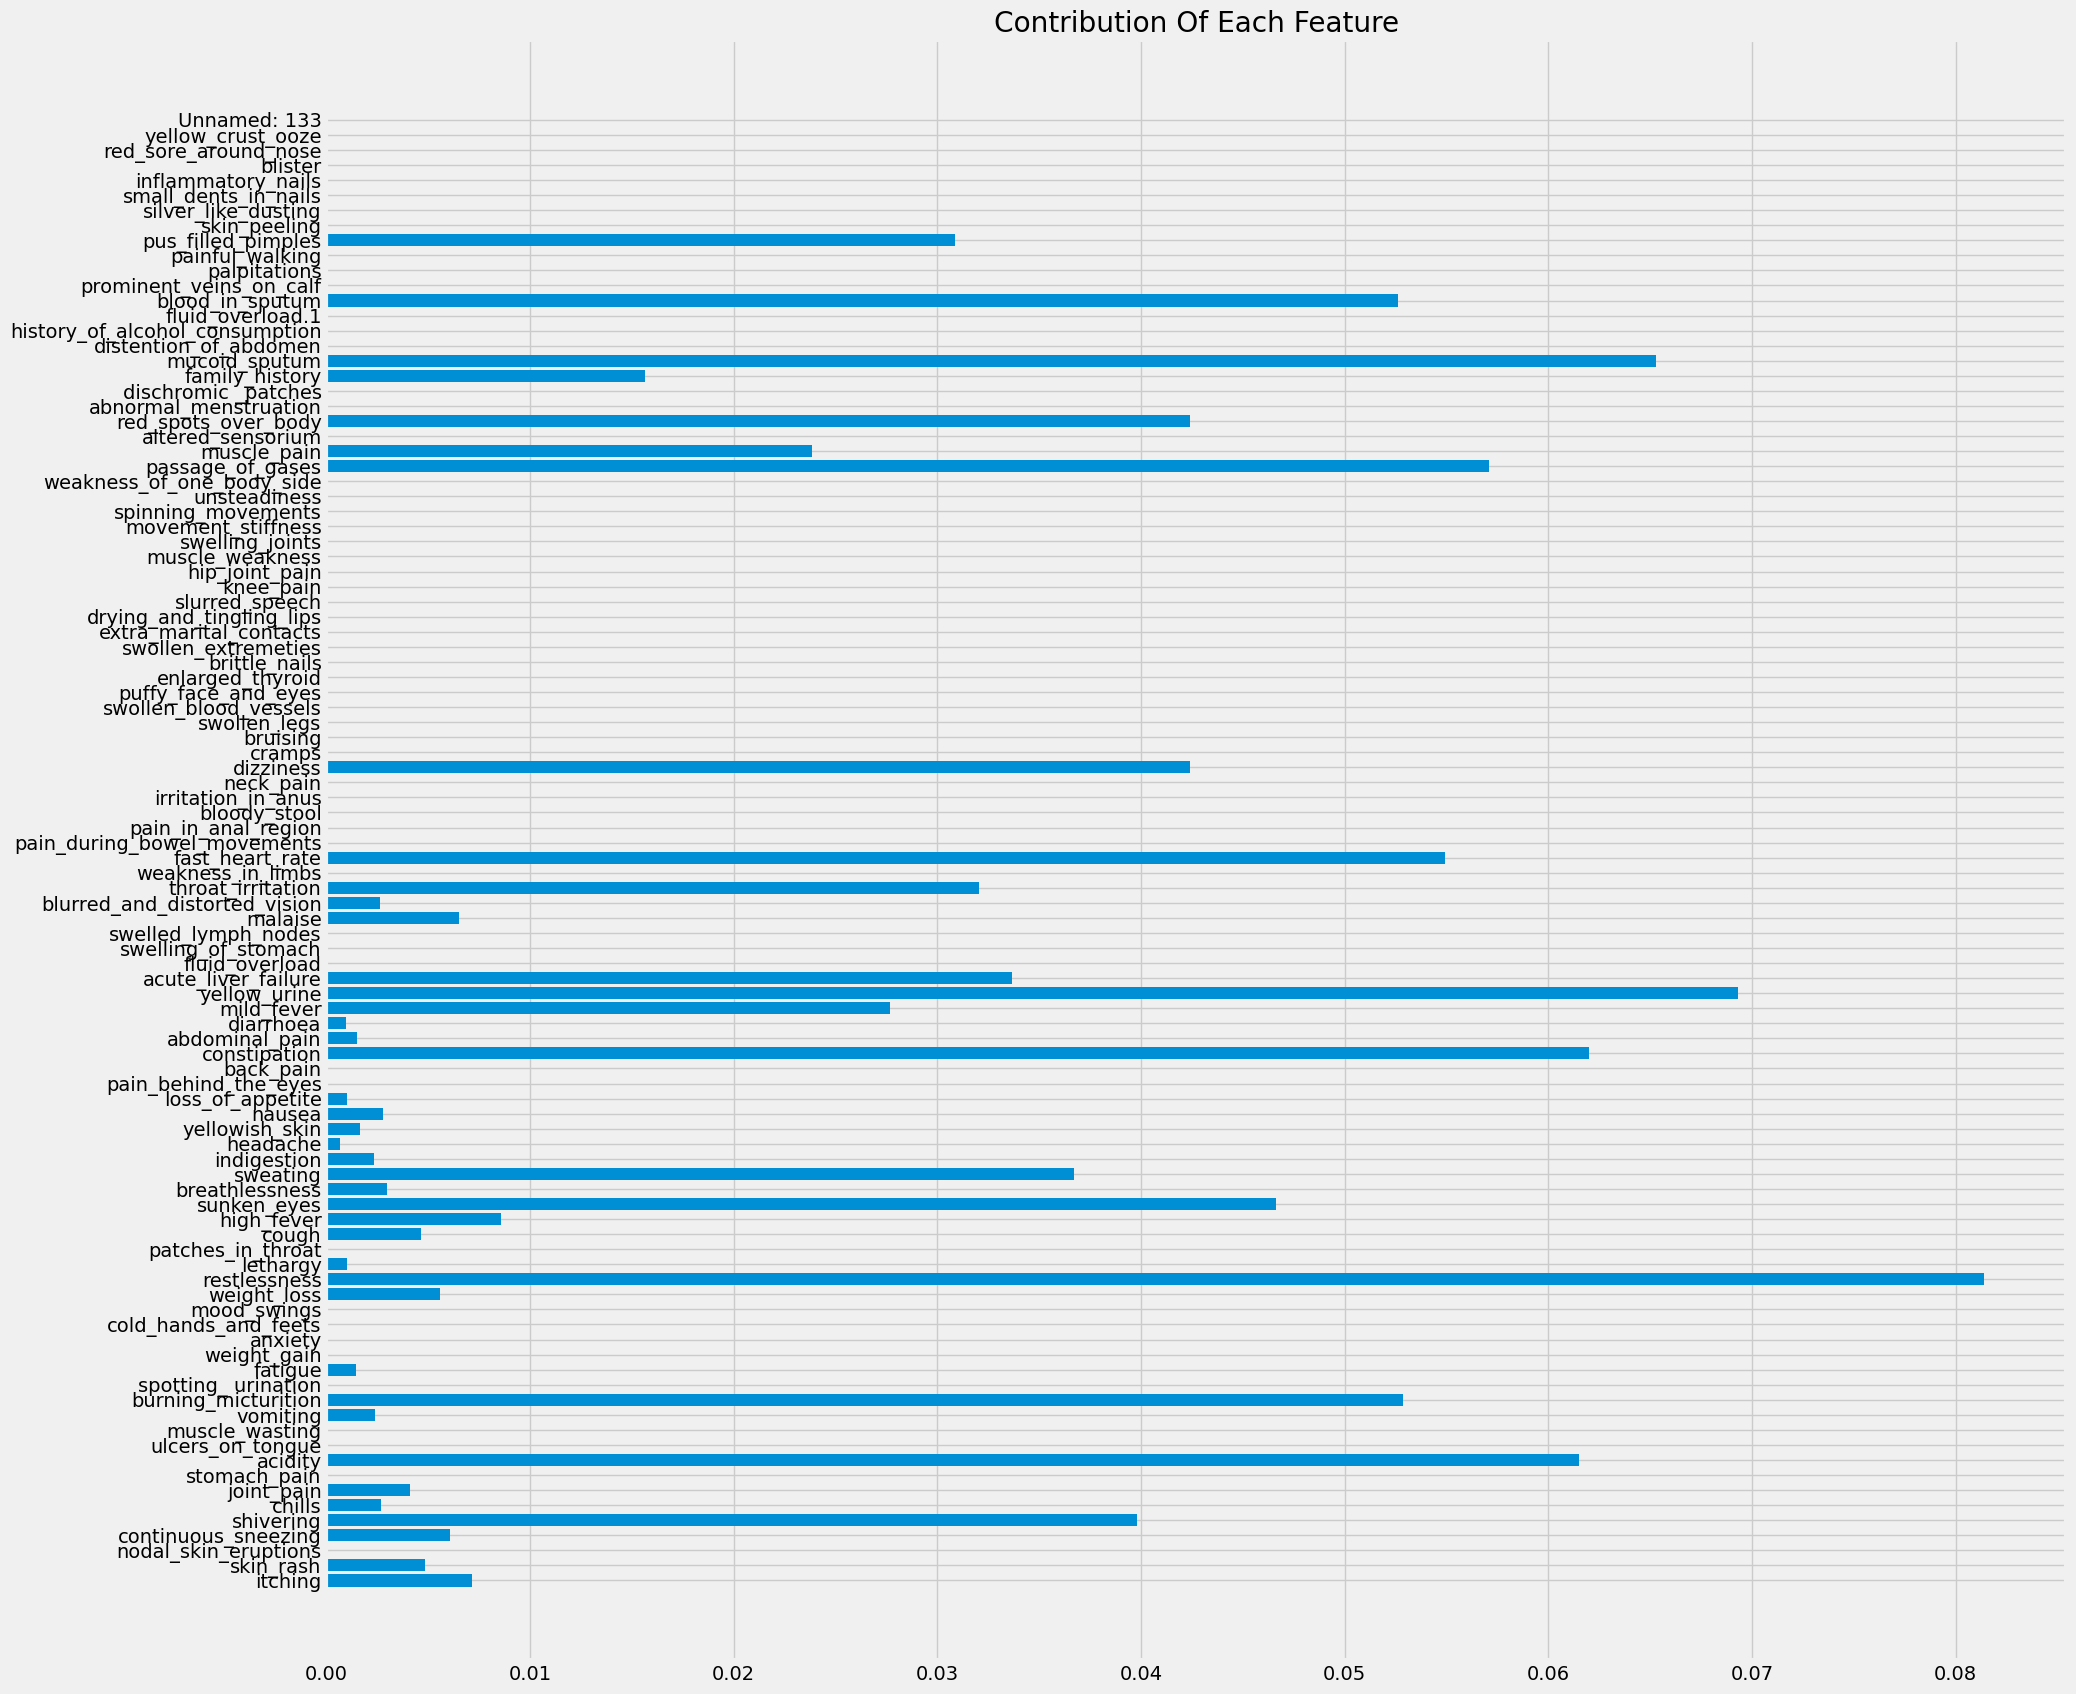

In [23]:
plt.figure(figsize=(20, 20))
plt.barh(x.columns, xgb.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

In [24]:
fi_df = pd.DataFrame({'Feature': x.columns, 'Importance': xgb.feature_importances_})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

fi_df.head(42)

,Feature,Importance
20,restlessness,0.081371
39,yellow_urine,0.069303
81,mucoid_sputum,0.065266
35,constipation,0.061984
8,acidity,0.061525
74,passage_of_gases,0.057100
48,fast_heart_rate,0.054908
12,burning_micturition,0.052873
85,blood_in_sputum,0.052611
25,sunken_eyes,0.046631


In [25]:
# Selecting only the top 45 features
fi_df['Feature'][: 42].unique()

array(['restlessness', 'yellow_urine', 'mucoid_sputum', 'constipation',
       'acidity', 'passage_of_gases', 'fast_heart_rate',
       'burning_micturition', 'blood_in_sputum', 'sunken_eyes',
       'dizziness', 'red_spots_over_body', 'shivering', 'sweating',
       'acute_liver_failure', 'throat_irritation', 'pus_filled_pimples',
       'mild_fever', 'muscle_pain', 'family_history', 'high_fever',
       'itching', 'malaise', 'continuous_sneezing', 'weight_loss',
       'skin_rash', 'cough', 'joint_pain', 'breathlessness', 'nausea',
       'chills', 'blurred_and_distorted_vision', 'vomiting',
       'indigestion', 'yellowish_skin', 'abdominal_pain', 'fatigue',
       'lethargy', 'loss_of_appetite', 'diarrhoea', 'headache',
       'inflammatory_nails'], dtype=object)

In [26]:
#Creating a new dataframe with the top features

new_df = train_data[['restlessness', 'constipation', 'acidity', 'mucoid_sputum',
       'yellow_urine', 'passage_of_gases', 'fast_heart_rate',
       'blood_in_sputum', 'burning_micturition', 'sunken_eyes',
       'dizziness', 'shivering', 'acute_liver_failure', 'sweating',
       'red_spots_over_body', 'pus_filled_pimples', 'throat_irritation',
       'mild_fever', 'muscle_pain', 'family_history',
       'swelled_lymph_nodes', 'itching', 'high_fever', 'skin_rash',
       'malaise', 'joint_pain', 'weight_loss', 'nausea',
       'blurred_and_distorted_vision', 'cough', 'continuous_sneezing',
       'breathlessness', 'loss_of_appetite', 'indigestion', 'vomiting',
       'chills', 'abdominal_pain', 'diarrhoea', 'lethargy',
       'yellowish_skin', 'fatigue', 'headache', 'prognosis']]

In [ ]:
new_df.head()

,restlessness,constipation,acidity,mucoid_sputum,yellow_urine,passage_of_gases,fast_heart_rate,blood_in_sputum,burning_micturition,sunken_eyes,...,loss_of_appetite,indigestion,vomiting,chills,abdominal_pain,diarrhoea,lethargy,yellowish_skin,fatigue,headache
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


- After dropping correlated columns and dropping columns with less feature importance, the remaining 46 columns will be used for further analysis and modelling.

## Exploratory Data Analysis
### Univariate analysis

In [27]:
#writing a function to plot two features
def countplot(first, second):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], ax = ax[0]).set_title(f"{first} distribution")
  sns.countplot(x = new_df[second], ax = ax[1]).set_title(f"{second} distribution")

  fig.show()

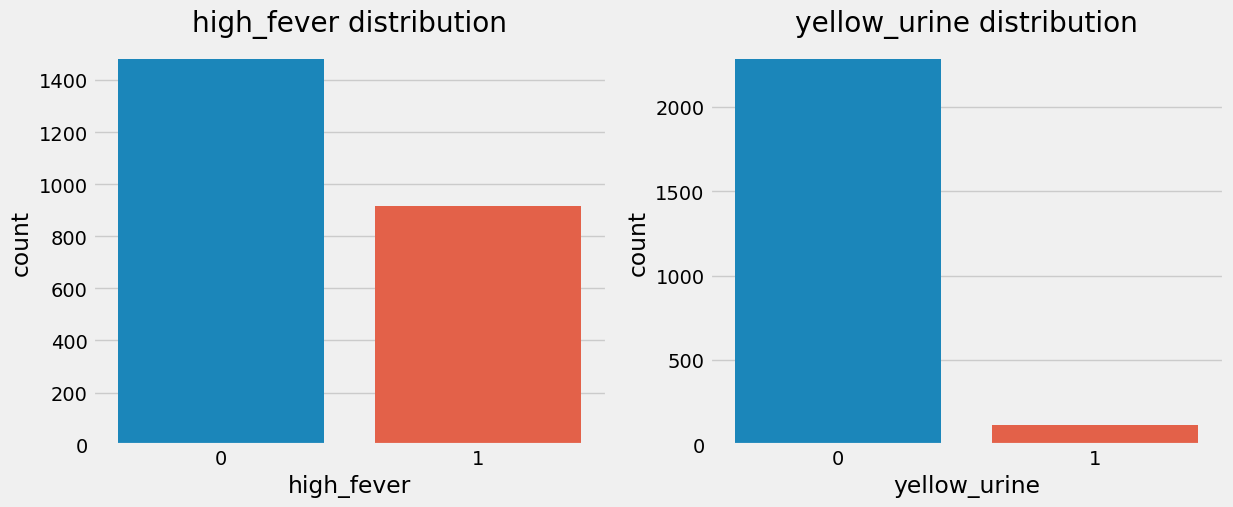

In [28]:
countplot('high_fever', 'yellow_urine')

- From the observation, most of the poeple do not have high fever and yellow urine.

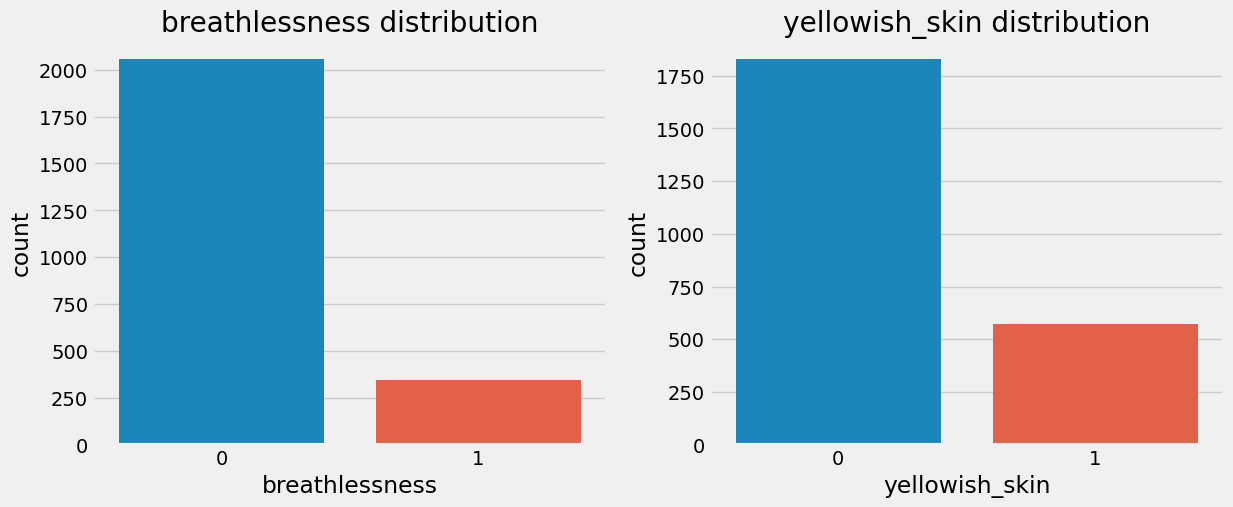

In [29]:
countplot('breathlessness', 'yellowish_skin')

- Most of the people do not have breathlessness as well as yellow skin

- Most of the people co not have muscle wasting and skin peeling and a correlation can be observed from the two features. One of the features will be dropped

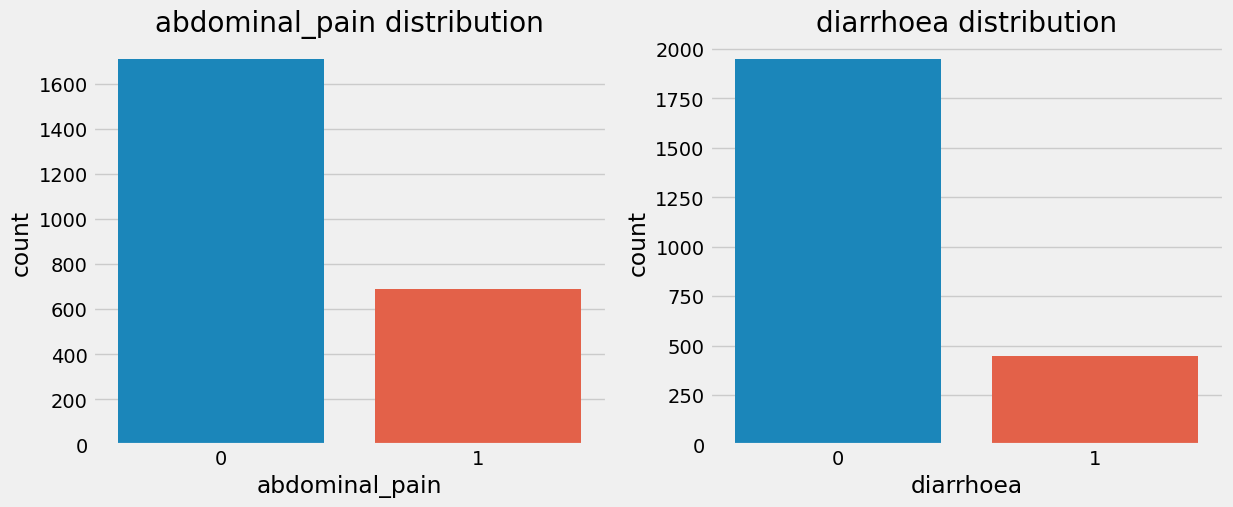

In [30]:
countplot('abdominal_pain', 'diarrhoea')

- Most of the observation doesn't have abdominal pain and diarrhoea

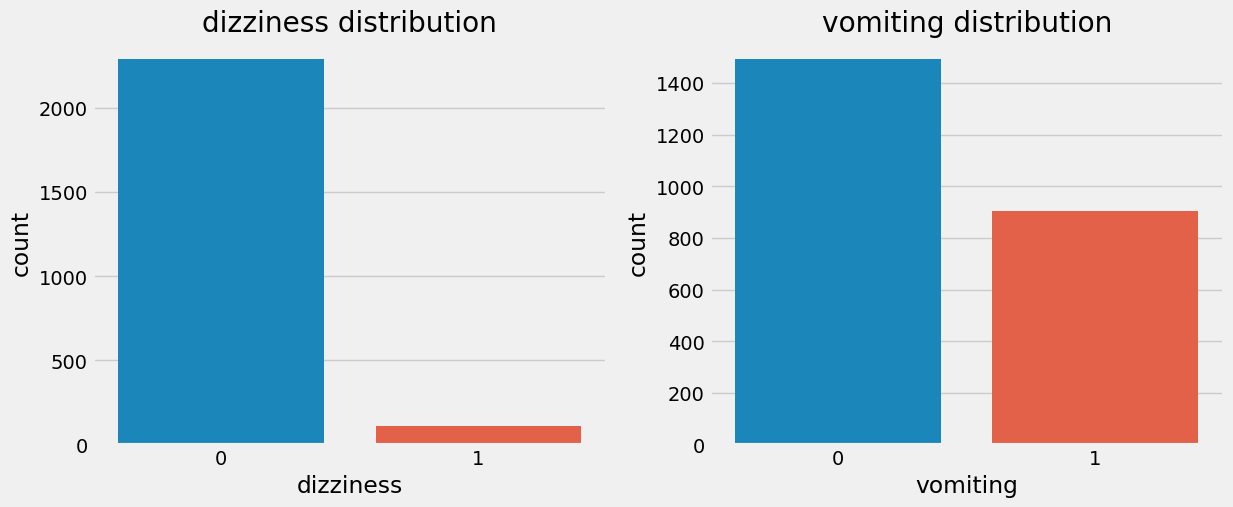

In [31]:
countplot('dizziness', 'vomiting')

- Most of the onbservation doesn't feel dizziness nor vomit

In [32]:
# Writing a function to get the value count for multiple columns
def mvc(first_column, second_columns, third_columns, fourth_columns, fifth_columns, sixth_columns, sevth_columns):
  columns = [first_column, second_columns, third_columns, fourth_columns, fifth_columns, sixth_columns, sevth_columns]

  for column in columns:
    value_counts = new_df[column].value_counts()
    print(f"Value Counts for {column}:\n{value_counts}")
    print("\n" + "-"*30 + "\n")

In [33]:
mvc('fast_heart_rate', 'dizziness', 'acute_liver_failure', 'sweating',
       'mild_fever', 'muscle_pain', 'swelled_lymph_nodes')

Value Counts for fast_heart_rate:
0    2280
1     120
Name: fast_heart_rate, dtype: int64

------------------------------

Value Counts for dizziness:
0    2292
1     108
Name: dizziness, dtype: int64

------------------------------

Value Counts for acute_liver_failure:
0    2286
1     114
Name: acute_liver_failure, dtype: int64

------------------------------

Value Counts for sweating:
0    2058
1     342
Name: sweating, dtype: int64

------------------------------

Value Counts for mild_fever:
0    2046
1     354
Name: mild_fever, dtype: int64

------------------------------

Value Counts for muscle_pain:
0    2040
1     360
Name: muscle_pain, dtype: int64

------------------------------

Value Counts for swelled_lymph_nodes:
0    2052
1     348
Name: swelled_lymph_nodes, dtype: int64

------------------------------



In [34]:
#Dropping columns that have similar value counts

new_df = new_df.drop(['restlessness', 'constipation', 'acidity', 'mucoid_sputum', 'yellow_urine', 'passage_of_gases', 'blood_in_sputum',
                      'burning_micturition', 'sunken_eyes', 'shivering', 'red_spots_over_body', 'weight_loss', 'blurred_and_distorted_vision',
                      'throat_irritation', 'pus_filled_pimples', 'family_history', 'skin_rash', 'indigestion', 'lethargy', 'sweating',
                      'joint_pain', 'loss_of_appetite', 'nausea', 'diarrhoea'], axis = 1)

In [35]:
new_df.columns

Index(['fast_heart_rate', 'dizziness', 'acute_liver_failure', 'mild_fever',
       'muscle_pain', 'swelled_lymph_nodes', 'itching', 'high_fever',
       'malaise', 'cough', 'continuous_sneezing', 'breathlessness', 'vomiting',
       'chills', 'abdominal_pain', 'yellowish_skin', 'fatigue', 'headache',
       'prognosis'],
      dtype='object')

## Bi variate Analysis

In [36]:
def countplott(first, second, third):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], hue = new_df[second], ax = ax[0]).set_title(f"Relationship between {first} and {second}")
  sns.countplot(x = new_df[first], hue = new_df[third], ax = ax[1]).set_title(f"Relationship between {first} and {third}")

  fig.show()

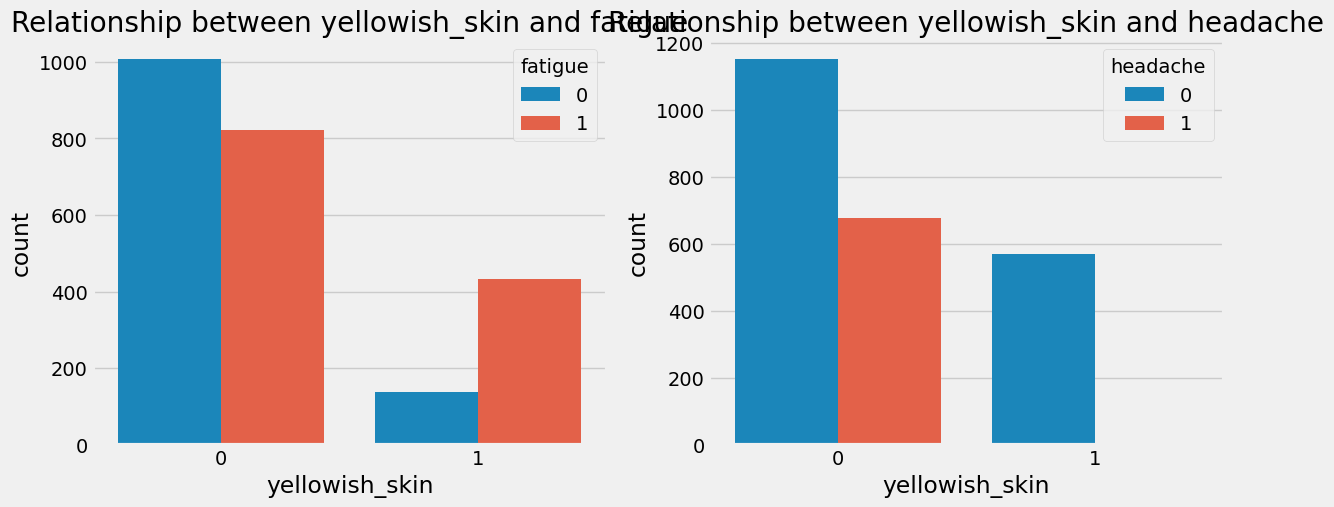

In [37]:
countplott('yellowish_skin', 'fatigue', 'headache')

- Most of the people that do not have yellowish skin fo not have fatigue and headache

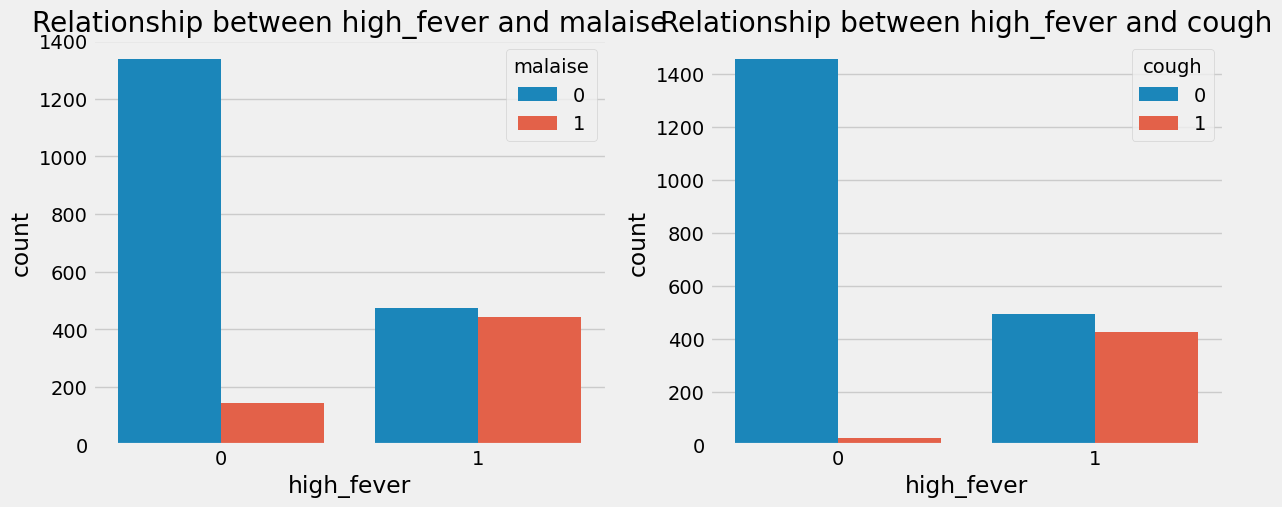

In [ ]:
countplott('high_fever', 'malaise', 'cough')

- Most of the people that do not have high fever do not have malaise and cough

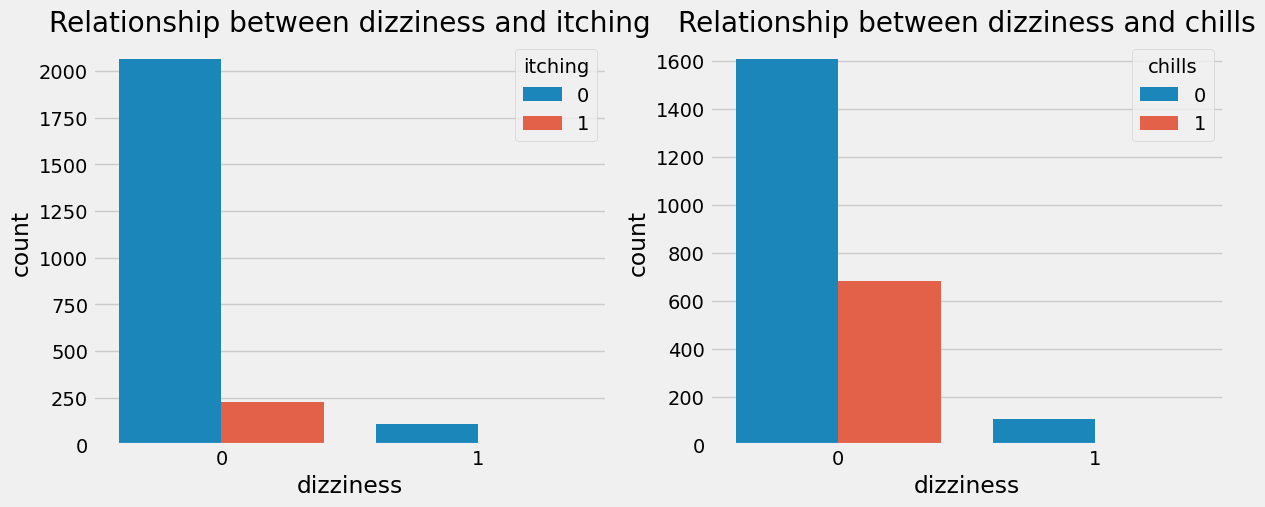

In [40]:
countplott('dizziness', 'itching', 'chills')

- only a few people feel dizziness and none of them have itchings
- Most of the people that feel dizziness have chills and itching as well

In [38]:
new_df.columns

Index(['fast_heart_rate', 'dizziness', 'acute_liver_failure', 'mild_fever',
       'muscle_pain', 'swelled_lymph_nodes', 'itching', 'high_fever',
       'malaise', 'cough', 'continuous_sneezing', 'breathlessness', 'vomiting',
       'chills', 'abdominal_pain', 'yellowish_skin', 'fatigue', 'headache',
       'prognosis'],
      dtype='object')

<Axes: >

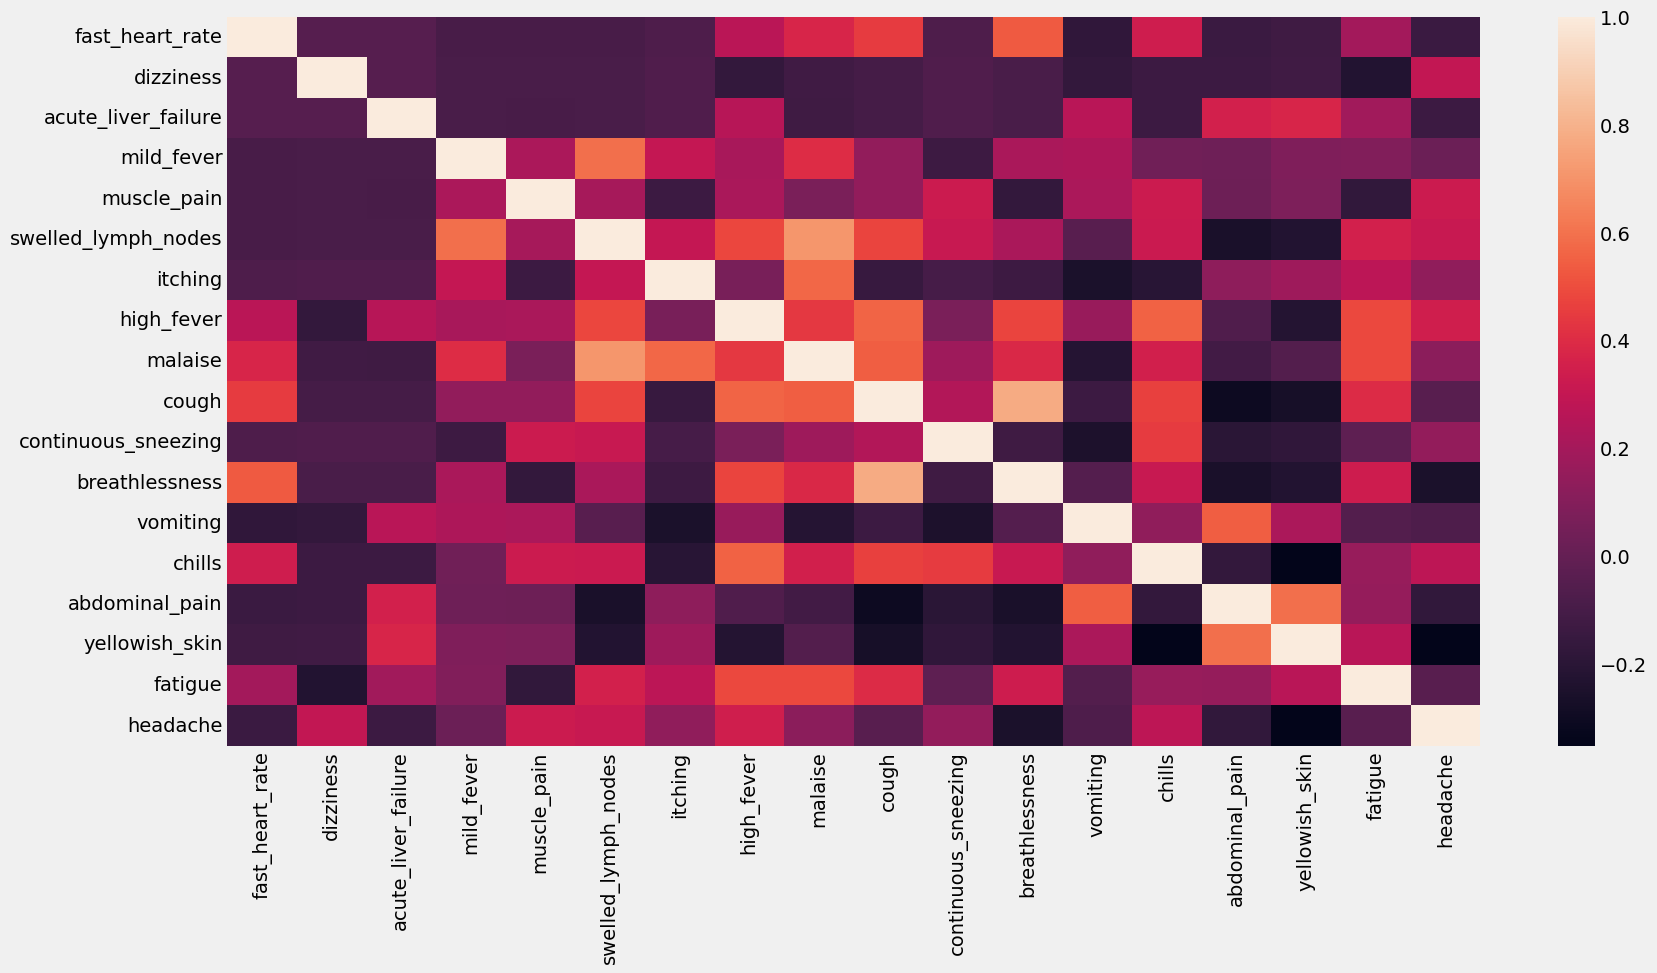

In [41]:
plt.figure(figsize = (18, 9))
sns.heatmap(new_df.corr())

In [42]:
#dropping more correlated columns
new_df = new_df.drop(['swelled_lymph_nodes', 'breathlessness'], axis = 1)

## Data Preprocessing

In [43]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 10 to 4917
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   fast_heart_rate      2400 non-null   int64 
 1   dizziness            2400 non-null   int64 
 2   acute_liver_failure  2400 non-null   int64 
 3   mild_fever           2400 non-null   int64 
 4   muscle_pain          2400 non-null   int64 
 5   itching              2400 non-null   int64 
 6   high_fever           2400 non-null   int64 
 7   malaise              2400 non-null   int64 
 8   cough                2400 non-null   int64 
 9   continuous_sneezing  2400 non-null   int64 
 10  vomiting             2400 non-null   int64 
 11  chills               2400 non-null   int64 
 12  abdominal_pain       2400 non-null   int64 
 13  yellowish_skin       2400 non-null   int64 
 14  fatigue              2400 non-null   int64 
 15  headache             2400 non-null   int64 
 16  progn

In [44]:
#mpping the target feature
pg = {'Allergy': 0, 'Peptic ulcer diseae': 1, 'Diabetes ': 2, 'Gastroenteritis': 3,
       'Bronchial Asthma': 4, 'Hypertension ': 5, 'Migraine': 6, 'Malaria': 7,
       'Chicken pox': 8, 'Typhoid': 9, 'hepatitis A': 10, 'Hepatitis B': 11,
       'Hepatitis C': 12, 'Hepatitis D': 13, 'Hepatitis E': 14, 'Tuberculosis': 15,
       'Common Cold': 16, 'Pneumonia': 17, 'Acne': 18, 'Urinary tract infection': 19}

new_df['prognosis'] = new_df['prognosis'].map(pg)

In [45]:
x = new_df.drop(['prognosis'], axis = 1)# independent features
y = new_df['prognosis']# dependent features

In [46]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

## Modelling and Evaluation

In [47]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
ct = CatBoostClassifier(verbose = False)
ct.fit(x_train, y_train)

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [51]:
#checking if xgboost is overfitted or underfitted with with cross validation
scores = cross_val_score(XGBClassifier(), x_train, y_train,
                              cv=10,
                              scoring="accuracy")

print("MAE score: ", scores.mean())

MAE score:
 0.9281250000000002


In [52]:
#checking if random forest is overfitted or underfitted with with cross validation
scores = cross_val_score(RandomForestClassifier(), x_train, y_train,
                              cv=10,
                              scoring="accuracy")

print("MAE score: ", scores.mean())

MAE score:  0.9281250000000002


In [53]:
#Writing a function to evaluate the performance of the models
def evaluate(model):
  y_pred = model.predict(x_test)
  print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}%\n")
  print(f"The F1 score of the {type(model).__name__} is {round(f1_score(y_test, y_pred, average='macro') * 100)}%\n")
  print(f"The recall score of the {type(model).__name__} is {round(recall_score(y_test, y_pred, average='macro') * 100)}%\n")
  print(f"The precision of the {type(model).__name__} is {round(precision_score(y_test, y_pred, average='macro') * 100)}%\n")

In [54]:
evaluate(xgb)

The accuracy score of the XGBClassifier is 94%

The F1 score of the XGBClassifier is 92%

The recall score of the XGBClassifier is 93%

The precision of the XGBClassifier is 91%



In [55]:
evaluate(ct)

The accuracy score of the CatBoostClassifier is 94%

The F1 score of the CatBoostClassifier is 92%

The recall score of the CatBoostClassifier is 93%

The precision of the CatBoostClassifier is 91%



In [56]:
evaluate(rf)

The accuracy score of the RandomForestClassifier is 94%

The F1 score of the RandomForestClassifier is 92%

The recall score of the RandomForestClassifier is 93%

The precision of the RandomForestClassifier is 91%



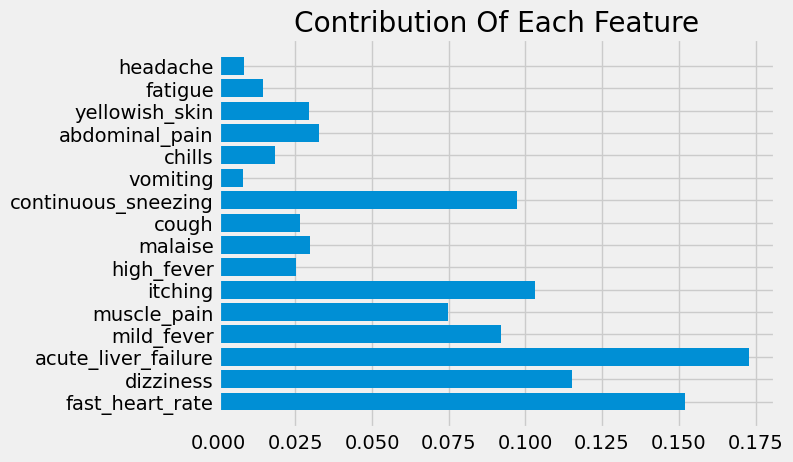

In [57]:
# plt.figure(figsize=(20, 20))
plt.barh(x.columns, xgb.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

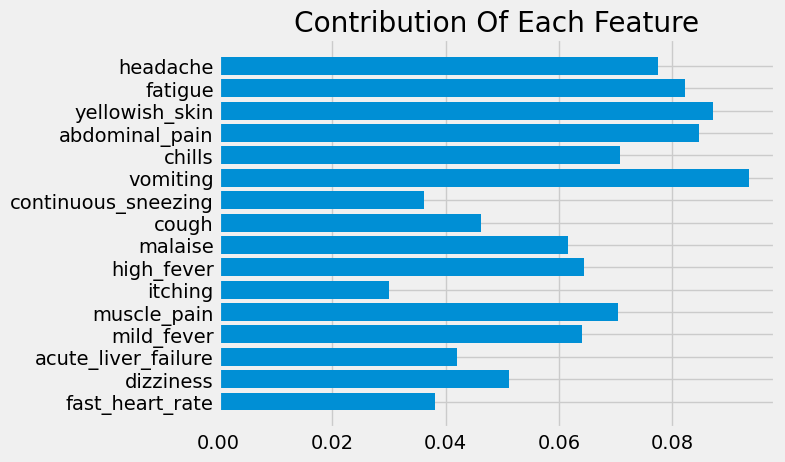

In [58]:
# plt.figure(figsize=(20, 20))
plt.barh(x.columns, rf.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

The models have the same performance but randome forest ensure more even distribution of the feature importance

## Hyparameter Tuning for RandomForest

In [60]:
# Model tuning with RandomSearchCV
kf = KFold(n_splits=10, shuffle=True, random_state=42)

max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
kf = KFold(n_splits = 5, shuffle = True, random_state = 5)
params = {'n_estimators': [int(x) for x in np.linspace(10, 100, num = 20)],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'max_depth': max_depth,
          'min_samples_split': [2, 5, 10], 'verbose': [int(x) for x in np.linspace(0, 20, num = 10)],
          'min_samples_leaf': [1, 2, 4], 'class_weight': ['balanced', 'balanced_subsample'],
          'bootstrap': [True, False], 'max_features': ['sqrt', 'log2', None]}

In [ ]:
rf_kf = RandomForestClassifier()
rf_tune = RandomizedSearchCV(rf_kf, params, cv = kf, n_iter = 2)
rf_tune.fit(x_train, y_train)

In [62]:
evaluate(rf_tune)

The accuracy score of the RandomizedSearchCV is 94%

The F1 score of the RandomizedSearchCV is 92%

The recall score of the RandomizedSearchCV is 93%

The precision of the RandomizedSearchCV is 91%



[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

- No improvement after parameter tuning with random search

In [59]:
#Saving/exporting the model
dump(rf, "model.joblib")

['model.joblib']